In [1]:
!pip install mapclassify

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.2/882.2 kB 13.4 MB/s eta 0:00:00


In [2]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 27.8 MB/s eta 0:00:00


In [3]:
# Common imports including dataframe management, mapping, file io, and helpers for extraction zips and tars
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import mapclassify

import seaborn as sns


import zipfile, tarfile
import os
import datetime
from pathlib import PurePath, Path

# Bring in requests for making HTTP API calls
import requests as req

In [42]:
# NOAA's Space Weather Prediction Center (SPWC)
aurora_data_url = 'https://services.swpc.noaa.gov/json/ovation_aurora_latest.json'

# Same data but from the G4 geomagnetic storm on 2025-11-12
peak_aurora_data_url = 'https://raw.githubusercontent.com/srujan964/ruc-gis/refs/heads/main/data/2025-11-12T04%3A59%3A51%2B00%3A00-aurora.csv'

In [95]:
USE_PEAK_DATA = True

if USE_PEAK_DATA:
  print('reading peak aurora data')
  # While reading csv data, convert the `coordinates` column to python's list type
  # NOTE: This seems to take a lot of time, need to find another, faster way to do this without evaluation the value from a string
  aurora_df = pd.read_csv(peak_aurora_data_url, converters={'coordinates': pd.eval})
else:
  print('reading current aurora data')
  aurora_df = pd.read_json(aurora_data_url)
aurora_df.head()

reading peak aurora data


,Unnamed: 0,Observation Time,Forecast Time,Data Format,coordinates,type
0,0,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[0, -90, 4]",MultiPoint
1,1,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[0, -89, 0]",MultiPoint
2,2,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[0, -88, 6]",MultiPoint
3,3,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[0, -87, 7]",MultiPoint
4,4,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[0, -86, 9]",MultiPoint


In [96]:
# all the values are for current time
aurora_df['Observation Time']

,Observation Time
0,2025-11-12T04:51:00Z
1,2025-11-12T04:51:00Z
2,2025-11-12T04:51:00Z
3,2025-11-12T04:51:00Z
4,2025-11-12T04:51:00Z
...,...
65155,2025-11-12T04:51:00Z
65156,2025-11-12T04:51:00Z
65157,2025-11-12T04:51:00Z
65158,2025-11-12T04:51:00Z


In [97]:
aurora_df['coordinates']

,coordinates
0,"[0, -90, 4]"
1,"[0, -89, 0]"
2,"[0, -88, 6]"
3,"[0, -87, 7]"
4,"[0, -86, 9]"
...,...
65155,"[359, 86, 0]"
65156,"[359, 87, 0]"
65157,"[359, 88, 0]"
65158,"[359, 89, 0]"


In [98]:
# Looking at only the Northern Hemisphere
# and within the longitudinal ranges of United States (including Alaska), with some padding

min_lat, max_lat = 1, 90
min_long, max_long = 0, 360

In [94]:
aurora_df['coordinates']

TypeError: dtype '<class 'list'>' not understood

In [99]:
# Explode coordinates into their own columns, makes it easier to query

split_columns = pd.DataFrame(aurora_df['coordinates'].tolist(), columns=['longitude', 'latitude', 'aurora'])
aurora_df = pd.concat([aurora_df, split_columns], axis=1)
aurora_df

,Unnamed: 0,Observation Time,Forecast Time,Data Format,coordinates,type,longitude,latitude,aurora
0,0,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[0, -90, 4]",MultiPoint,0,-90,4
1,1,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[0, -89, 0]",MultiPoint,0,-89,0
2,2,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[0, -88, 6]",MultiPoint,0,-88,6
3,3,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[0, -87, 7]",MultiPoint,0,-87,7
4,4,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[0, -86, 9]",MultiPoint,0,-86,9
...,...,...,...,...,...,...,...,...,...
65155,65155,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[359, 86, 0]",MultiPoint,359,86,0
65156,65156,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[359, 87, 0]",MultiPoint,359,87,0
65157,65157,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[359, 88, 0]",MultiPoint,359,88,0
65158,65158,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[359, 89, 0]",MultiPoint,359,89,0


In [100]:
aurora_df = aurora_df[aurora_df['longitude'].isin(range(min_long, max_long+1)) & aurora_df['latitude'].isin(range(min_lat, max_lat + 1))]
aurora_df

,Unnamed: 0,Observation Time,Forecast Time,Data Format,coordinates,type,longitude,latitude,aurora
91,91,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[0, 1, 0]",MultiPoint,0,1,0
92,92,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[0, 2, 0]",MultiPoint,0,2,0
93,93,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[0, 3, 0]",MultiPoint,0,3,0
94,94,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[0, 4, 0]",MultiPoint,0,4,0
95,95,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[0, 5, 0]",MultiPoint,0,5,0
...,...,...,...,...,...,...,...,...,...
65155,65155,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[359, 86, 0]",MultiPoint,359,86,0
65156,65156,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[359, 87, 0]",MultiPoint,359,87,0
65157,65157,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[359, 88, 0]",MultiPoint,359,88,0
65158,65158,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[359, 89, 0]",MultiPoint,359,89,0


In [101]:
longitudes = np.array(aurora_df['longitude'])
np.mod(-longitudes, 360) - 180

array([-180, -180, -180, ..., -179, -179, -179])

In [102]:
aurora_corrected_df = aurora_df.copy()
# Convert longitudes from [0, 360] to [180, -180]
aurora_corrected_df['longitude'] = np.mod( - np.array(aurora_df['longitude']), 360) -180

aurora_corrected_df

,Unnamed: 0,Observation Time,Forecast Time,Data Format,coordinates,type,longitude,latitude,aurora
91,91,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[0, 1, 0]",MultiPoint,-180,1,0
92,92,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[0, 2, 0]",MultiPoint,-180,2,0
93,93,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[0, 3, 0]",MultiPoint,-180,3,0
94,94,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[0, 4, 0]",MultiPoint,-180,4,0
95,95,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[0, 5, 0]",MultiPoint,-180,5,0
...,...,...,...,...,...,...,...,...,...
65155,65155,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[359, 86, 0]",MultiPoint,-179,86,0
65156,65156,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[359, 87, 0]",MultiPoint,-179,87,0
65157,65157,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[359, 88, 0]",MultiPoint,-179,88,0
65158,65158,2025-11-12T04:51:00Z,2025-11-12T05:52:00Z,"[Longitude, Latitude, Aurora]","[359, 89, 0]",MultiPoint,-179,89,0


In [13]:
aurora_df.query('latitude == 0 & aurora > 0')

,Observation Time,Forecast Time,Data Format,coordinates,type,longitude,latitude,aurora


In [103]:
# Giant dataset from the CEC (International Collaboration on Environment Issues) with elevation data for Canada, United States, and Mexico
!curl -o elevation.zip https://www.cec.org/files/atlas_layers/0_reference/0_03_elevation/elevation_mappackage.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  659M  100  659M    0     0  28.3M      0  0:00:23  0:00:23 --:--:-- 30.3M


In [16]:
# Nightime lights dataset from the same source - https://www.cec.org/files/atlas_layers/4_human_influence/4_01_nighttime_lights_2010/nighttimelights_2010_mappackage.zip

In [17]:
elevation_zipfile = zipfile.ZipFile('elevation.zip')
elevation_dir = 'elevation'
if not os.path.isdir(elevation_dir):
  os.mkdir(elevation_dir)
if len(os.listdir(elevation_dir)) == 0:
  elevation_zipfile.extractall(elevation_dir)

In [18]:
!pip install py7zr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.0/97.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.7/51.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 429.9/429.9 kB 25.0 MB/s eta 0:00:00


In [19]:
import py7zr

mpkg_dir = PurePath(elevation_dir, 'elevation_mappackage')
mpkg_file = Path(mpkg_dir, 'Elevation.mpkx')

elevation_data_dir = PurePath(elevation_dir, 'data')
if not os.path.isdir(elevation_data_dir):
  os.mkdir(elevation_data_dir)

with py7zr.SevenZipFile(mpkg_file, 'r') as sevenz_file:
  sevenz_file.extractall(str(elevation_data_dir))


<Axes: >

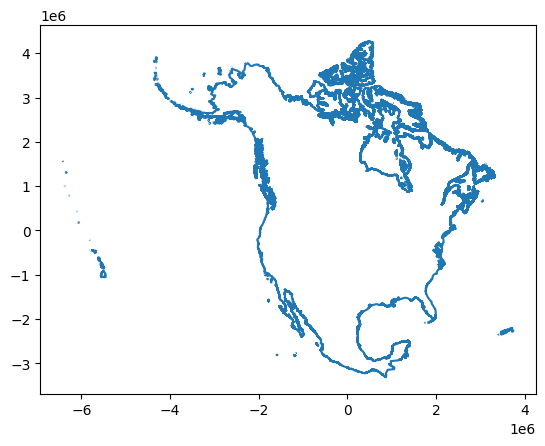

In [20]:
coastline_gdf = gpd.read_file('elevation/data/commondata/na_coastline/northamerica_coastline_v3.shp')

coastline_gdf.plot()

In [21]:
coastline_gdf.crs

<Projected CRS: PROJCS["Sphere_ARC_INFO_Lambert_Azimuthal_Equal_Ar ...>
Name: Sphere_ARC_INFO_Lambert_Azimuthal_Equal_Area
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Azimuthal Equal Area (Spherical)
Datum: D_Sphere_ARC_INFO
- Ellipsoid: Sphere_ARC_INFO
- Prime Meridian: Greenwich

In [22]:
coastline_gdf.head()

,COUNTRY,LENGTH_KM,LENGTH_MTS,geometry
0,MEX,2,1588,"LINESTRING (802083.011 -3250567.651, 802003.91..."
1,MEX,1,721,"LINESTRING (801829.498 -3250101.649, 801864.04..."
2,MEX,3,3488,"LINESTRING (792387.849 -3249186.56, 792491.83 ..."
3,MEX,1,1080,"LINESTRING (792533.354 -3249099.411, 792468.49..."
4,MEX,11,10830,"LINESTRING (797332.76 -3247069.489, 797406.816..."


<Axes: >

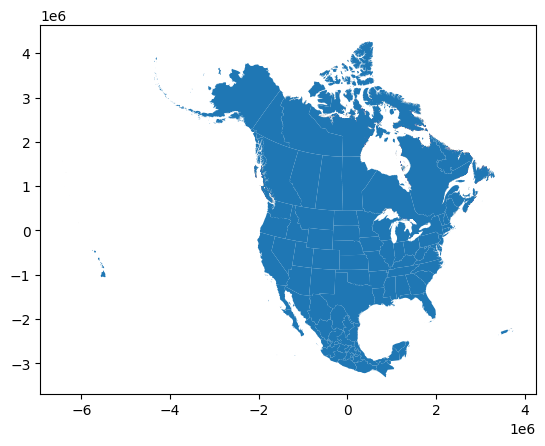

In [23]:
na_gdf = gpd.read_file('elevation/data/commondata/na_politicaldivisions/boundaries_p_2021_v3.shp')

na_gdf.plot()

In [24]:
na_gdf.crs

<Projected CRS: PROJCS["Sphere_ARC_INFO_Lambert_Azimuthal_Equal_Ar ...>
Name: Sphere_ARC_INFO_Lambert_Azimuthal_Equal_Area
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Azimuthal Equal Area (Spherical)
Datum: D_Sphere_ARC_INFO
- Ellipsoid: Sphere_ARC_INFO
- Prime Meridian: Greenwich

In [107]:
crs_lambert_azimuthal = na_gdf.crs

In [25]:
na_gdf_4326 = na_gdf.to_crs('EPSG:4326')

<Axes: >

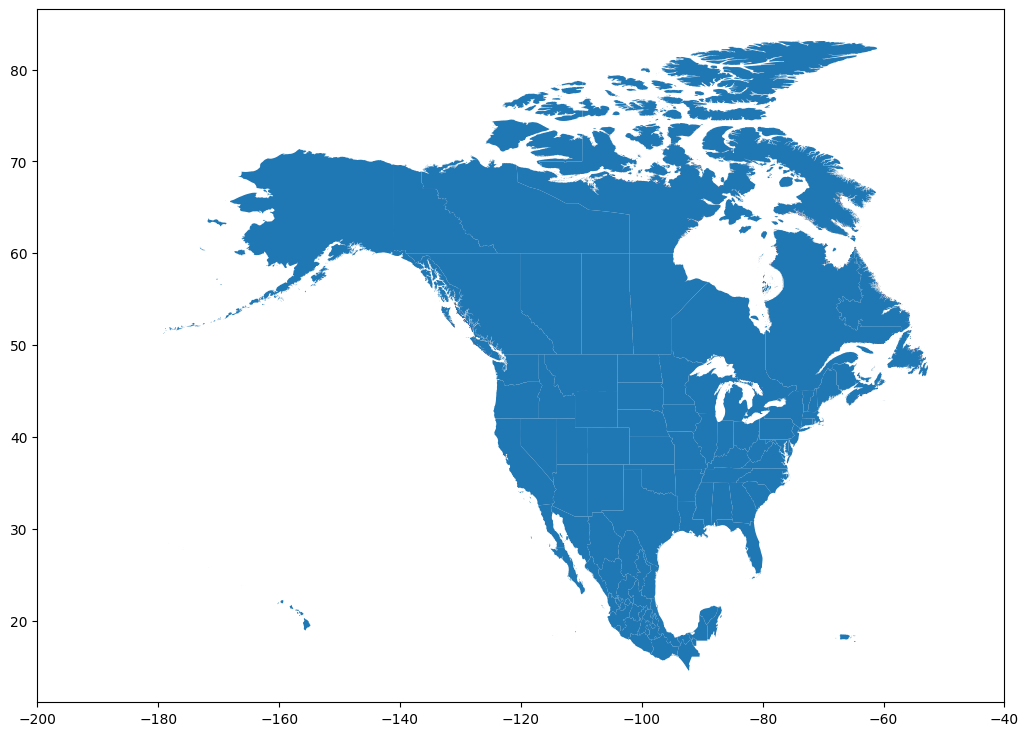

In [26]:
fig, ax = plt.subplots(1, figsize=(16,9))
ax.set_xlim([-200, -40])
na_gdf_4326.plot(ax=ax)

In [104]:
aurora_points = gpd.GeoDataFrame(aurora_corrected_df, geometry=gpd.points_from_xy(aurora_corrected_df.longitude, aurora_corrected_df.latitude), crs='EPSG:4326')

In [105]:

from matplotlib.colors import LinearSegmentedColormap
def aurora_cmap():
  stops = {'red': [(0.00, 0.1725, 0.1725),
                      (0.50, 0.1725, 0.1725),
                      (1.00, 0.8353, 0.8353)],

              'green': [(0.00, 0.9294, 0.9294),
                        (0.50, 0.9294, 0.9294),
                        (1.00, 0.8235, 0.8235)],

              'blue': [(0.00, 0.3843, 0.3843),
                        (0.50, 0.3843, 0.3843),
                        (1.00, 0.6549, 0.6549)],

              'alpha': [(0.00, 0.0, 0.0),
                        (0.50, 1.0, 1.0),
                        (1.00, 1.0, 1.0)]}
  return LinearSegmentedColormap('aurora', stops)



In [115]:
# Convert the aurora map to Lambert-Azimuthal Equal Area projection to match the original projection of the base map
# This preserves the curvature of Northern polar region that compliments the shape of Aurora formation
aurora_points_lambert = aurora_points.to_crs(crs_lambert_azimuthal)

<Axes: >

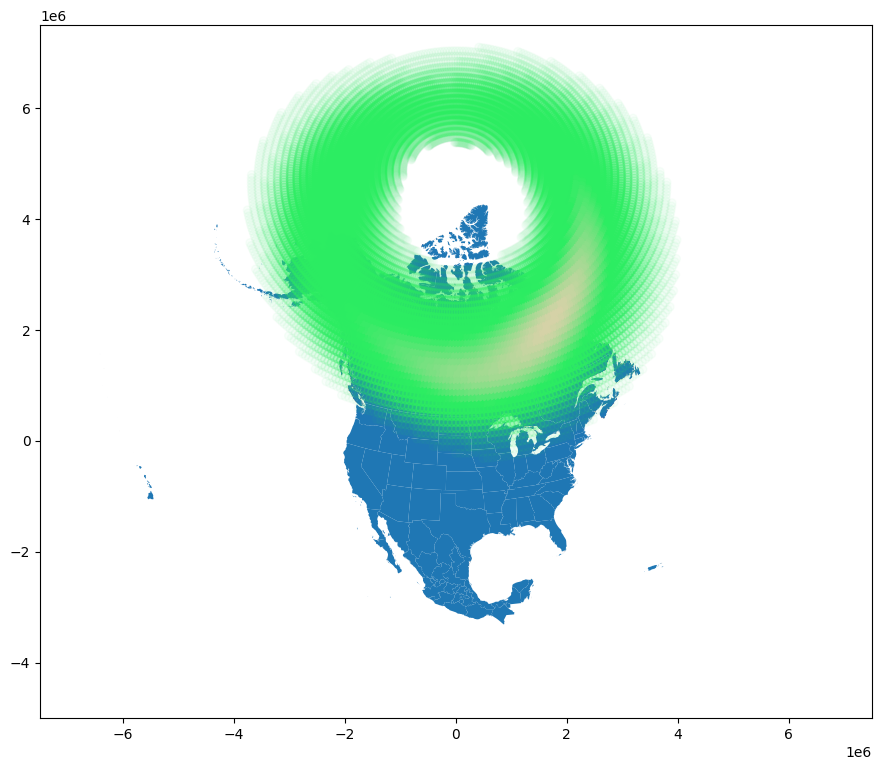

In [116]:
fig, ax = plt.subplots(1, figsize=(16,9))

# Limit the axes, which are no longer in lat-long coordinates but in metres.
ax.set_xlim([-0.75e7, 0.75e7])
ax.set_ylim([-0.50e7, 0.75e7])
na_gdf.plot(ax=ax)

aurora_points_lambert.plot(ax=ax, cmap=aurora_cmap(), column='aurora')